# Aplicación de librerías skforecast en la resolución de pronósticos
## Este resolución fue preparada utilizando la publicación de Joaquín Amat Rodrigo y Javier Escobar Ortiz

Skforecast: forecasting series temporales con Python, Machine Learning y Scikit-learn por <b>Joaquín Amat Rodrigo y Javier Escobar Ortiz<b>, disponible bajo una licencia Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0 DEED) en https://www.cienciadedatos.net/documentos/py27-forecasting-series-temporales-python-scikitlearn.html


In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modelado y Forecasting
# ==============================================================================
import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
#import shap


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m' 
print(f"{color}Versión skforecast: {skforecast.__version__}")
print(f"{color}Versión scikit-learn: {sklearn.__version__}")
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión numpy: {np.__version__}")

Versión skforecast: 0.13.0
Versión scikit-learn: 1.5.1
Versión pandas: 2.2.2
Versión numpy: 2.0.1


In [2]:
# Descarga de datos
# ==============================================================================
datos = fetch_dataset(name='h2o_exog', raw=True)

h2o_exog
--------
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008. Two additional variables (exog_1, exog_2) are
simulated.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice (3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,
https://github.com/robjhyndman/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (195, 4)


In [3]:
# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y-%m-%d')
datos = datos.set_index('fecha')
datos = datos.asfreq('MS')
datos = datos.sort_index()
datos.head()
print(f'Número de filas con missing values: {datos.isnull().any(axis=1).mean()}')

Número de filas con missing values: 0.0


In [4]:
# Verificar que un índice temporal está completo
# ==============================================================================
fecha_inicio = datos.index.min()
fecha_fin = datos.index.max()
date_range_completo = pd.date_range(start=fecha_inicio, end=fecha_fin, freq=datos.index.freq)
print(f"Índice completo: {(datos.index == date_range_completo).all()}")

Índice completo: True


### Se utilizan los últimos 36 meses como conjunto de test para evaluar la capacidad predictiva del modelo.

Fechas train : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Fechas test  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


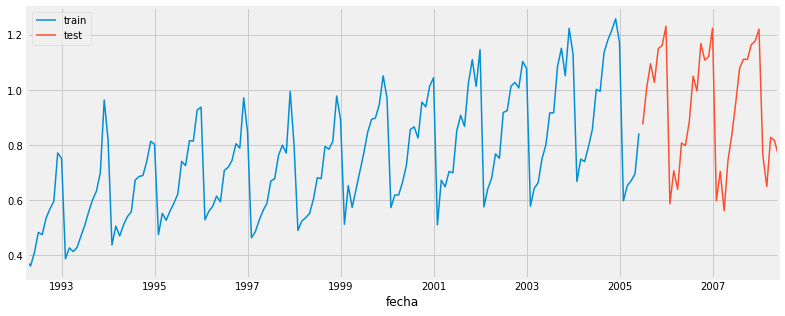

In [5]:
# Separación datos train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]
print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(12, 5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
ax.legend();

# Forecasting autorregresivo recursivo
## ForecasterAutoreg
Se crea y entrena un modelo ForecasterAutoreg a partir de un regresor RandomForestRegressor y una ventana temporal de 6 lags. Esto último significa que, el modelo, utiliza como predictores los 6 meses anteriores.

In [6]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 12
             )
forecaster.fit(y=datos_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-08-22 20:03:35 
Last fit date: 2024-08-22 20:03:36 
Skforecast version: 0.13.0 
Py

## Predicciones
Una vez entrenado el modelo, se predicen los datos de test (36 meses a futuro).

In [7]:
# Predicciones
# ==============================================================================
steps = 36
predicciones = forecaster.predict(steps=steps)
predicciones.head(5)

2005-07-01    0.932374
2005-08-01    0.965877
2005-09-01    1.110397
2005-10-01    1.135135
2005-11-01    1.142431
Freq: MS, Name: pred, dtype: float64

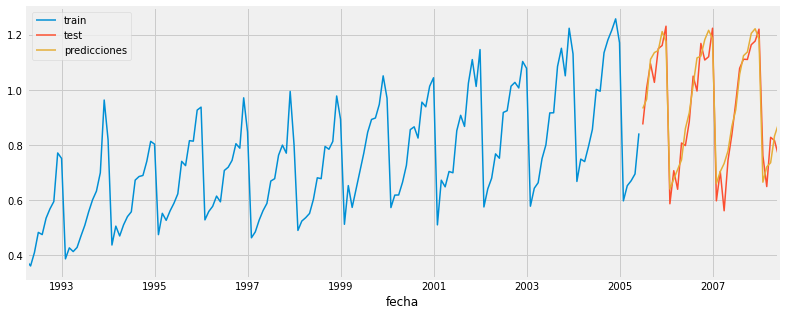

In [8]:
# Gráfico de predicciones vs valores reales
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

## Error de predicción en los datos de test
Se cuantifica el error que comete el modelo en sus predicciones.  <br>
Se lo realiza comparando los valores pronosticados con la serie de testeo que reservamos. <br>
Se utilizan los 3 errores clásicos. <br>
<b>MAP</b>  (aquí se llama MAE mean absolute error) <br>
<b>MAPE</b> (que es la visión porcentual del error anterior) <br>
<b>MSE</b>  (error quadrático medio) <br>

In [9]:
# Error test
# ==============================================================================
error_mae = round(mean_absolute_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            ),4)

error_mape = round(mean_absolute_percentage_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            ) * 100,2)

error_mse = round(mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            ),4)

print(f"Error de test (MAD): {error_mae}")
print(f"Error de test (MAPE): {error_mape} %")
#print('Error de test (MAPE) %i :' %(round(error_mape,2)))
print(f"Error de test (MSE): {error_mse}")

Error de test (MAD): 0.0542
Error de test (MAPE): 6.47 %
Error de test (MSE): 0.0042


## Ajuste de hiperparámetros (tuning)
El ForecasterAutoreg entrenado ha utilizado una ventana temporal de 6 lags y un modelo Random Forest con los hiperparámetros por defecto. Sin embargo, no hay ninguna razón por la que estos valores sean los más adecuados. La librería Skforecast proporciona varias estrategias de búsqueda para encontrar la mejor combinación de hiperparámetros y lags. En este caso, se utiliza la función grid_search_forecaster, que compara los resultados obtenidos con cada combinación de hiperparámetros y lags, e identifica la mejor.

In [10]:
# Búsqueda de hiperparámetros: grid search
# ==============================================================================
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 6 # Este valor será remplazado en el grid search
             )

# Valores candidatos de lags
lags_grid = [10, 20]

# Valores candidatos de hiperparámetros del regresor
param_grid = {
      'n_estimators': [100, 250],
      'max_depth': [3, 5, 10]
}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        n_jobs             = 'auto',
                        verbose            = False
                  )

Number of models compared: 12.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 250}
  Backtesting metric: 0.02177319540541341



In [11]:
# Resultados de la búsqueda de hiperparámetros
# ==============================================================================
resultados_grid


,lags,lags_label,params,mean_squared_error,max_depth,n_estimators
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 250}",0.021773,3,250
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 250}",0.021852,5,250
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 250}",0.021909,10,250
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.022530,5,100
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.022569,3,100
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",0.023400,10,100
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",0.063144,3,100
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 250}",0.064241,3,250
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.066307,10,100
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.067151,5,100


## Modelo final
Finalmente, se entrena de nuevo un ForecasterAutoreg con la mejor configuración encontrada. Este paso no es necesario si se indica return_best = True en la función grid_search_forecaster.

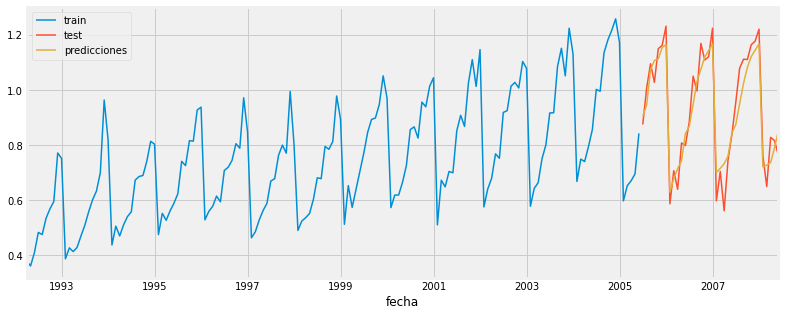

In [12]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )
forecaster.fit(y=datos_train['y'])

# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps)

# Gráfico de predicciones vs valores reales
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [13]:
# Error test
# ==============================================================================
error_mae = round(mean_absolute_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            ),4)

error_mape = round(mean_absolute_percentage_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            ) * 100,2)

error_mse = round(mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            ),4)

print(f"Error de test (MAD): {error_mae}")
print(f"Error de test (MAPE): {error_mape} %")
#print('Error de test (MAPE) %i :' %(round(error_mape,2)))
print(f"Error de test (MSE): {error_mse}")

Error de test (MAD): 0.055
Error de test (MAPE): 6.45 %
Error de test (MSE): 0.0044
